# Voting Feature Intervals (VFI)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Pre-processing

In [2]:
from lib import pre_processing
file_path = "./data/features_3_sec.csv"
df = pd.read_csv(file_path)
df = pre_processing(df)

## Data Normalization

In [3]:
from lib import normalize_df
df = normalize_df(df)

In [4]:
df_numpy = df.to_numpy()
X = df_numpy[:,:-1]
y = df_numpy[:, -1]

In [5]:
X.shape, y.shape

((9990, 57), (9990,))

## Model Evaluation

### Multiclass VFI

In [6]:
import vfi
from sklearn.model_selection import train_test_split

def fit_vfi(X, y, test_size):
    # Train-validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
    # Fit the model
    vfi_model = vfi.VFI()
    vfi_model = vfi_model.fit(X_train, y_train)
    y_pred = vfi_model.predict(X_test)
    
    # Return the accuracy
    return ((y_test == y_pred).sum() / len(y_test))

In [7]:
accuracy = fit_vfi(X, y, 0.25)
print(f"| Genre: multiclass | Accuracy: {accuracy:.3%} |")

| Genre: multiclass | Accuracy: 49.119% |


### Balanced Binary Classifiers

We want classes to have the same number of elements.

Therefore, we will randomly select samples from the other classes.

In [8]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock']

In [9]:
from lib import balance_classes
for genre in genres:
    Xi, yi = balance_classes(X, y, genre)
    accuracy = fit_vfi(Xi, yi, 0.25)
    print(f"| Genre: {genre:9} | Accuracy: {accuracy:.3%} |")

| Genre: blues     | Accuracy: 79.600% |
| Genre: classical | Accuracy: 88.577% |
| Genre: country   | Accuracy: 67.735% |
| Genre: disco     | Accuracy: 75.400% |
| Genre: hiphop    | Accuracy: 79.960% |
| Genre: jazz      | Accuracy: 80.000% |
| Genre: metal     | Accuracy: 83.800% |
| Genre: pop       | Accuracy: 86.000% |
| Genre: reggae    | Accuracy: 80.800% |
| Genre: rock      | Accuracy: 69.138% |


### Cross-validation

In [10]:
from sklearn.model_selection import KFold

def cross_validate(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    accuracy_list = []
    
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

        # Fit the model and compute predictions
        vfi_model = vfi.VFI()
        vfi_model = vfi_model.fit(X_train, y_train)
        y_pred = vfi_model.predict(X_test)
        
        accuracy = (y_test == y_pred).sum() / len(y_test)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

### Static partitioning (train-validation split)

In [11]:
test_sizes = [0.1, 0.25, 0.33]

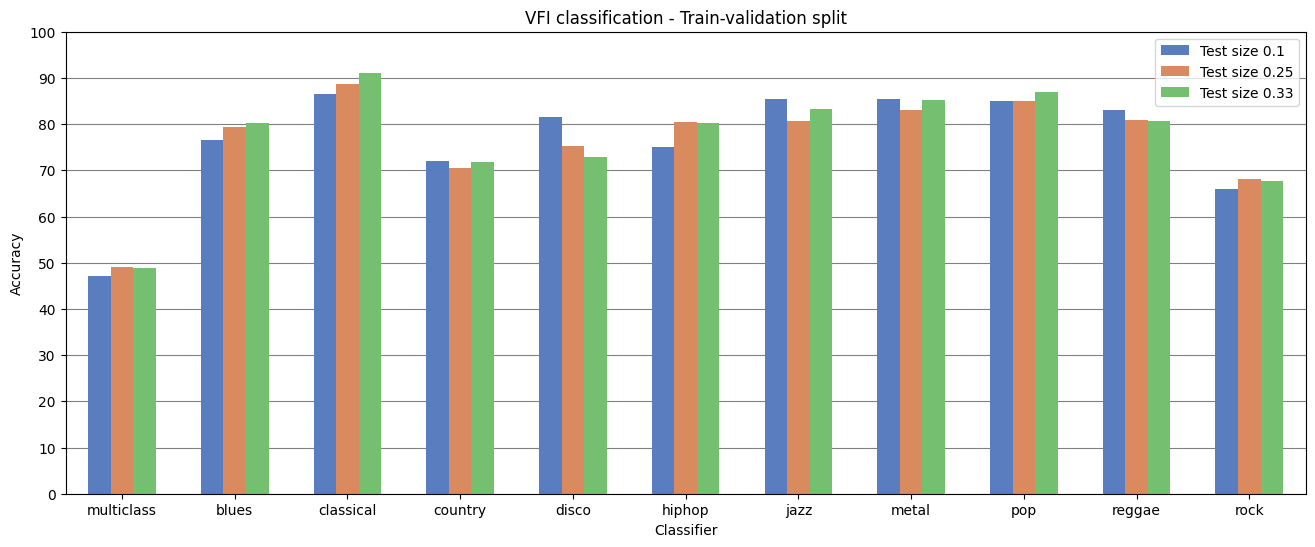

In [12]:
from lib import plot_evaluation_results
sp_results = []

for test_size in test_sizes:
    # Multiclass classifier
    accuracy = fit_vfi(X, y, test_size)
    sp_results.append(('multiclass', accuracy*100, f'Test size {test_size}'))
    
    # Binary classifiers
    for genre in genres:
        Xi, yi = balance_classes(X, y, genre)
        accuracy = fit_vfi(Xi, yi, test_size)
        sp_results.append((genre, accuracy*100, f'Test size {test_size}'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=('label', 'accuracy', 'size'))
plot_evaluation_results(results_df, 'VFI classification - Train-validation split')

## Dynamic partitioning (cross-validation)

In [13]:
folds = [5, 10, 20]

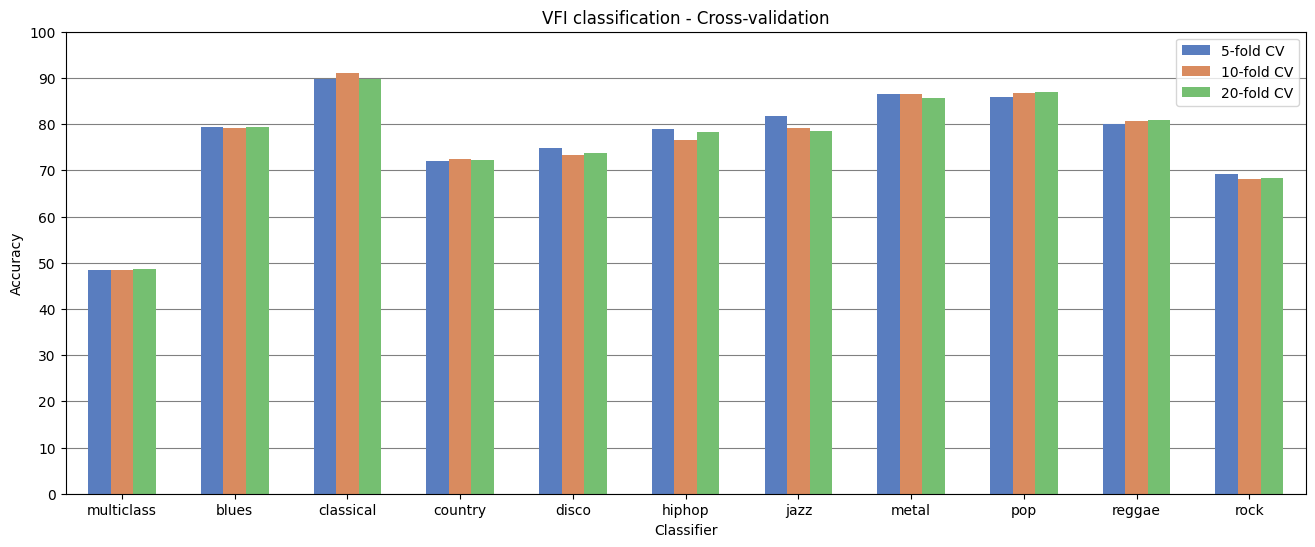

In [14]:
sp_results = []

for fold in folds:
    # Multiclass classifier
    accuracy = cross_validate(X, y, fold)
    sp_results.append(('multiclass', accuracy*100, f'{fold}-fold CV'))
    
    # Binary classifiers
    for genre in genres:
        Xi, yi = balance_classes(X, y, genre)
        accuracy = cross_validate(Xi, yi, fold)
        sp_results.append((genre, accuracy*100, f'{fold}-fold CV'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=('label', 'accuracy', 'size'))   
plot_evaluation_results(results_df, 'VFI classification - Cross-validation')

# Multiclass confusion matrix

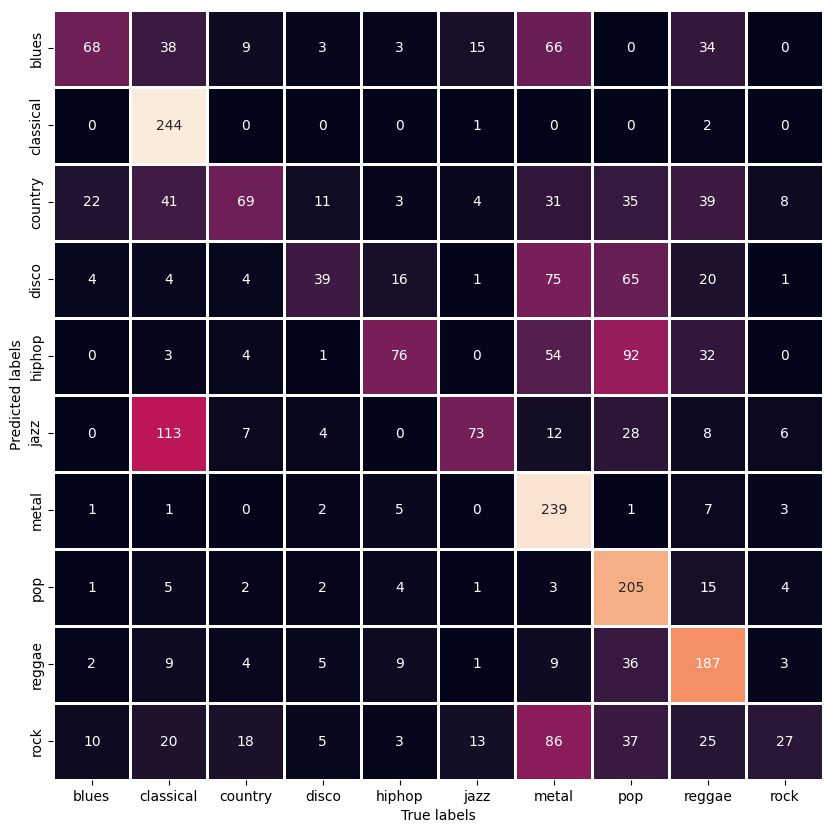

In [15]:
from lib import plot_confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
vfi = vfi.VFI()
vfi = vfi.fit(X_train, y_train)
y_pred = vfi.predict(X_test)
plot_confusion_matrix(y_test, y_pred, genres)